# Convolutional Neural Networks for Animal Image Classification

**Objective:** Compare baseline dense networks with CNN architectures and analyze the role of convolutional layers in image classification tasks using a multi-class animal dataset.

## Dataset Selection and Justification

We use the [Animal Computer Vision Clean Dataset & Code CNN-AI](https://www.kaggle.com/datasets/emirhanai/animal-computer-vision-clean-dataset-code-cnnai?resource=download) dataset from Kaggle, developed by *Emirhan Bulut*. This dataset contains high-quality images of four animal classes:

* Zebra
* Rhino
* Elephant
* Buffalo

The dataset consists of 4000 images (≈228 MB), making it significantly larger and more diverse than toy datasets, while still being manageable for experimentation with convolutional neural networks.

This dataset is well suited for the assignment because:

* It is image-based and specifically designed for computer vision tasks
* The classes present distinct visual characteristics (body shape, texture, size, patterns), ideal for convolutional feature extraction
* The dataset size allows meaningful training of CNNs while still exposing risks such as overfitting in simpler dense architectures
* It enables a clear and fair comparison between fully connected networks and CNN-based models

Additionally, the dataset has been previously validated in a CNN-based classification pipeline, achieving high performance metrics (≈97% accuracy), which makes it a reliable benchmark for analyzing architectural design choices rather than data quality issues.

The dataset encourages the use of intentional CNN architectures, emphasizing the importance of convolutional layers, spatial feature learning, and inductive bias in image classification problems.

## Setup and Imports

In [4]:
# Install required libraries (run this once if needed)
# %pip install numpy pandas matplotlib tensorflow scikit-learn
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from PIL import Image

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU Available: []


## 1. Dataset Exploration (EDA)

In [2]:
# define datset path
DATASET_PATH = "./data/Animals"
CLASSES = ['Buffalo', 'Elephant', 'Rhino', 'Zebra']
NUM_CLASSES = len(CLASSES)
IMG_SIZE = (128, 128)
INPUT_SHAPE = (*IMG_SIZE, 3)

In [3]:
# Analyze dataset structure
def analyze_dataset_structure(dataset_path):
    class_counts = {}
    image_dimensions = []
    
    for class_name in CLASSES:
        class_path = os.path.join(DATASET_PATH, class_name)
        if os.path.exists(class_path):
            images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
            class_counts[class_name] = len(images)
            
            # Sample a few images to check dimensions
            for img_file in images[:5]:
                img_path = os.path.join(class_path, img_file)
                try:
                    img = Image.open(img_path)
                    image_dimensions.append(img.size)
                except:
                    pass
    
    return class_counts, image_dimensions

class_counts, image_dims = analyze_dataset_structure(DATASET_PATH)

print("Dataset Summary:")
print(f"\nTotal classes: {NUM_CLASSES}")
print(f"Total images: {sum(class_counts.values())}")
print(f"\nClass Distribution:")
for class_name, count in class_counts.items():
    print(f"  {class_name:12s}: {count:3d} images ({count/sum(class_counts.values())*100:.1f}%)")

Dataset Summary:

Total classes: 4
Total images: 4000

Class Distribution:
  Buffalo     : 1000 images (25.0%)
  Elephant    : 1000 images (25.0%)
  Rhino       : 1000 images (25.0%)
  Zebra       : 1000 images (25.0%)


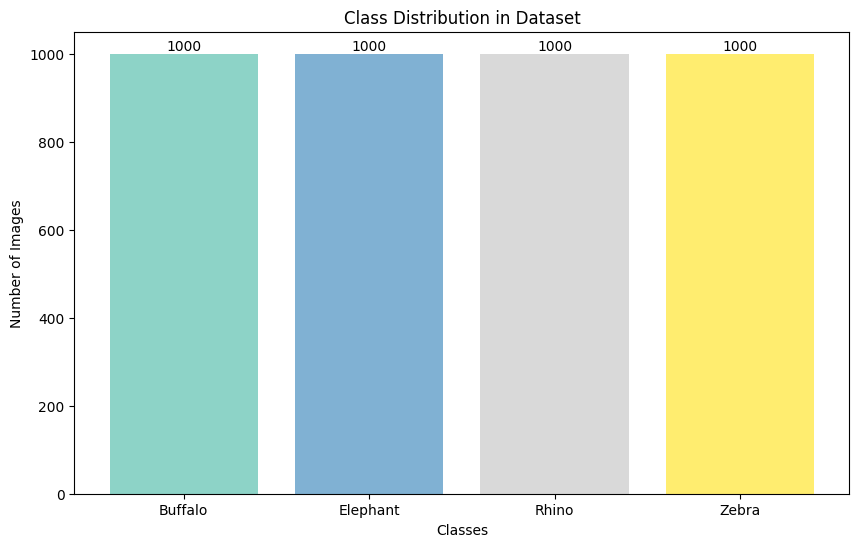

In [4]:
# Visualize class distribution
plt.figure(figsize=(10, 6))
colors = plt.cm.Set3(np.linspace(0, 1, len(class_counts)))
plt.bar(class_counts.keys(), class_counts.values(), color=colors)
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Dataset')
# Add value labels on bars
for i, count in enumerate(class_counts.values()):
    plt.text(i, count + 1, str(count), ha='center', va='bottom')
plt.show()


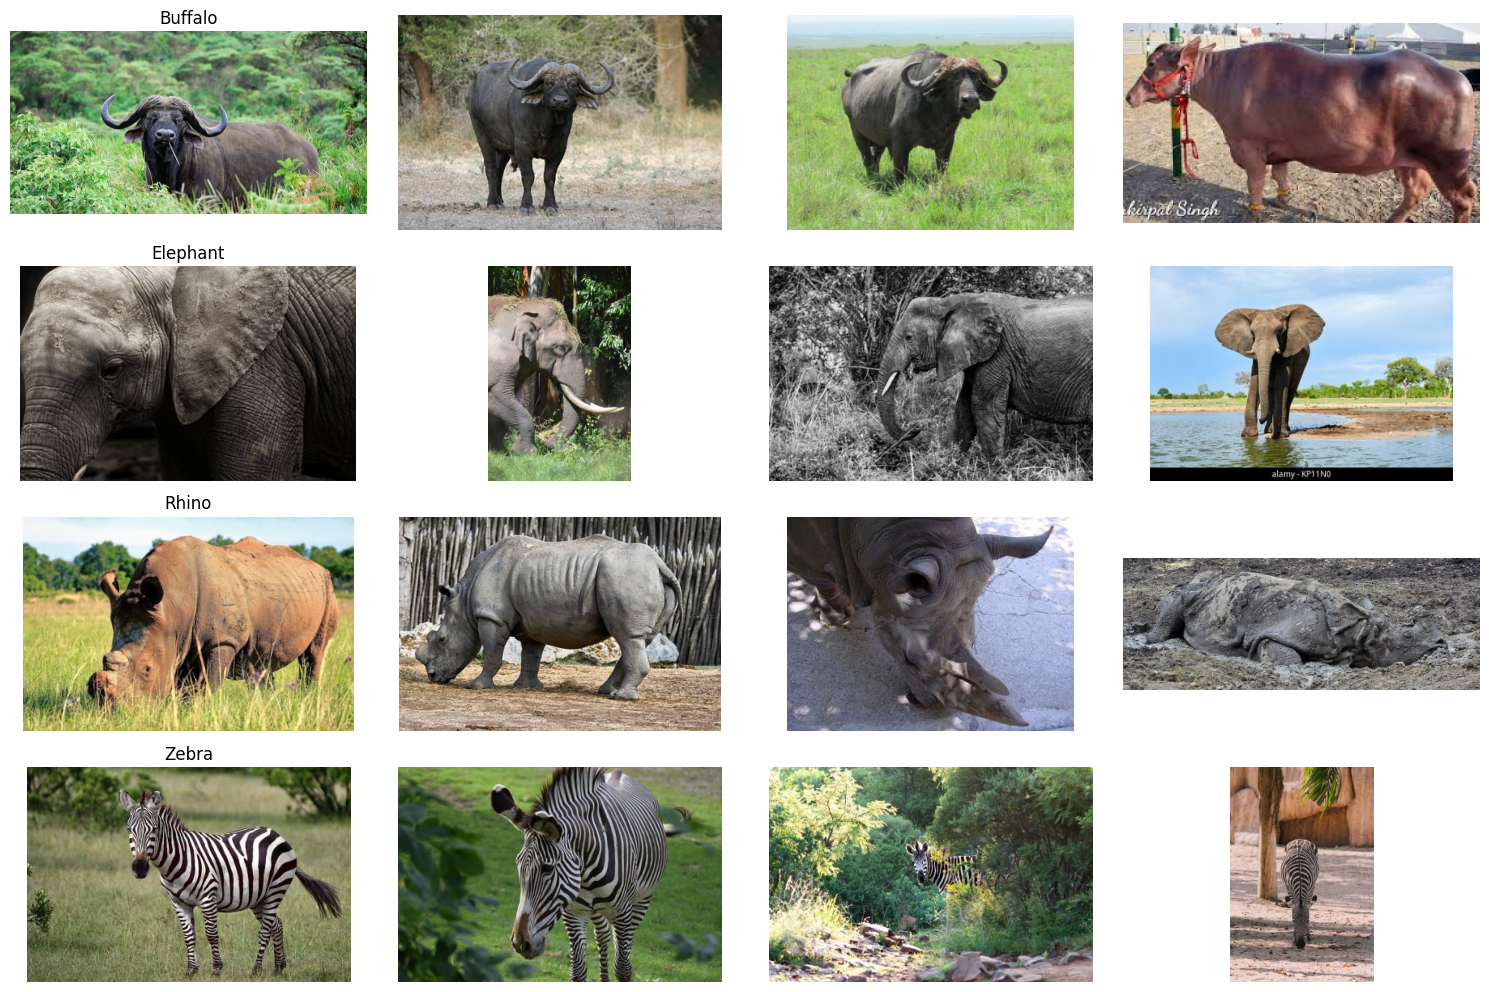

In [5]:
# Display sample images from each class
def display_sample_images(dataset_path, classes, num_samples=4):
    plt.figure(figsize=(15, 10))
    
    for i, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.exists(class_path):
            images = [f for f in os.listdir(class_path) 
                     if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
            sample_images = images[:num_samples]
            
            for j, img_file in enumerate(sample_images):
                img_path = os.path.join(class_path, img_file)
                try:
                    img = plt.imread(img_path)
                    plt.subplot(len(classes), num_samples, i * num_samples + j + 1)
                    plt.imshow(img)
                    plt.axis('off')
                    if j == 0:
                        plt.title(class_name)
                except Exception as e:
                    print(f"Error loading {img_file}: {e}")
                    plt.subplot(len(classes), num_samples, i * num_samples + j + 1)
                    plt.imshow(np.zeros((100, 100, 3)))
                    plt.axis('off')
                    if j == 0:
                        plt.title(f"{class_name} (error)")
    
    plt.tight_layout()
    plt.show()

display_sample_images(DATASET_PATH, CLASSES)

### Data Loading and Preprocessing
Load images and labels, resize, and normalize.
Preprocessing steps:
1. Resize all images to consistent dimensions
2. Convert to RGB (in case of grayscale)
3. Normalize pixel values to [0, 1]

In [8]:
def load_dataset(dataset_path, classes, img_size):
    images = []
    labels = []
    failed_count = 0
    
    for class_idx, cls in enumerate(classes):
        cls_path = os.path.join(dataset_path, cls)
        files = [f for f in os.listdir(cls_path) 
                 if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
        
        print(f"Loading {cls}: {len(files)} images...", end=' ')
        
        for fname in files:
            fpath = os.path.join(cls_path, fname)
            try:
                img = keras.preprocessing.image.load_img(
                    fpath, target_size=img_size, color_mode='rgb'
                )
                img_array = keras.preprocessing.image.img_to_array(img) / 255.0
                images.append(img_array)
                labels.append(class_idx)
            except Exception as e:
                failed_count += 1
                print(f"\n  Failed to load {fname}: {e}")
        print(f"Loaded {len([l for l in labels if l == class_idx])} images")
    
    X = np.array(images, dtype=np.float32)
    y = np.array(labels, dtype=np.int32)
    
    return X, y

X, y = load_dataset(DATASET_PATH, CLASSES, IMG_SIZE)

print(f"\nLoaded {len(X)} images with shape {X[0].shape}")
print(f"Memory usage: {X.nbytes / (1024**2):.2f} MB")

Loading Buffalo: 1000 images... Loaded 1000 images
Loading Elephant: 1000 images... Loaded 1000 images
Loading Rhino: 1000 images... Loaded 1000 images
Loading Zebra: 1000 images... Loaded 1000 images

Loaded 4000 images with shape (128, 128, 3)
Memory usage: 750.00 MB


In [9]:
# Train/validation/test split
# First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=SEED, stratify=y
)

# Second split: 15% val, 15% test from the 30% temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=SEED, stratify=y_temp
)
# Convert labels to categorical
y_train_cat = to_categorical(y_train, NUM_CLASSES)
y_val_cat = to_categorical(y_val, NUM_CLASSES)
y_test_cat = to_categorical(y_test, NUM_CLASSES)

print(f"Training set: {len(X_train)} images {len(X_train)/len(X)*100:.1f}%")
print(f"Validation set: {len(X_val)} images {len(X_val)/len(X)*100:.1f}%")
print(f"Test set: {len(X_test)} images {len(X_test)/len(X)*100:.1f}%")

Training set: 2800 images 70.0%
Validation set: 600 images 15.0%
Test set: 600 images 15.0%


## 2. Baseline Model (Non-Convolutional)

Baseline approach: Fully connected (Dense) neural network

Architecture rationale:
- Flatten the 128×128×3 image into a 49,152-dimensional vector
- Use 2-3 hidden dense layers with decreasing neurons
- Apply dropout for regularization
- No spatial structure preservation

Expected limitations:
- Loss of spatial relationships
- Massive parameter count
- No translation invariance
- Prone to overfitting on small datasets

In [11]:
def crate_baseline_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Flatten(input_shape=input_shape, name='flatten'),
        layers.Dense(256, activation='relu', name='dense_1'),
        layers.Dropout(0.3, name='dropout_1'),
        layers.Dense(128, activation='relu', name='dense_2'),
        layers.Dropout(0.3, name='dropout_2'),
        layers.Dense(num_classes, activation='softmax', name='output')
    ], name='Baseline_Dense_NN')

    return model

input_shape = X_train.shape[1:]
baseline_model = crate_baseline_model(INPUT_SHAPE, NUM_CLASSES)
baseline_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
baseline_model.summary()

C:\Users\mayer\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "Baseline_Dense_NN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │    12,583,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,616,580 (48.13 MB)

 Trainable params: 12,616,580 (48.13 MB)

 Non-trainable params: 0 (0.00 B)

### Training the Baseline

In [13]:
# Train configuration
EPOCHS = 20
BATCH_SIZE = 32
early_stopping = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True, 
        verbose=1,
        min_delta=1e-4
    ),
]

history_baseline = baseline_model.fit(
    X_train, y_train_cat, 
    validation_data=(X_val, y_val_cat), 
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    callbacks=early_stopping, 
    verbose=1
)

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 0.2357 - loss: 1.3889 - val_accuracy: 0.2500 - val_loss: 1.3863
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - accuracy: 0.2446 - loss: 1.3861 - val_accuracy: 0.2500 - val_loss: 1.3863
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - accuracy: 0.2293 - loss: 1.3862 - val_accuracy: 0.2500 - val_loss: 1.3863
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - accuracy: 0.2346 - loss: 1.3860 - val_accuracy: 0.2500 - val_loss: 1.3863
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.2311 - loss: 1.3860 - val_accuracy: 0.2500 - val_loss: 1.3863
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 0.2393 - loss: 1.3872 - val_accuracy: 0.2500 - val_loss: 1.3863
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - accuracy: 0.2286 - loss: 1.3852 - val_accuracy: 0.2500 - val_loss: 1.3863
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step - accuracy: 0.2371 - loss: 1.3851 - val_accu

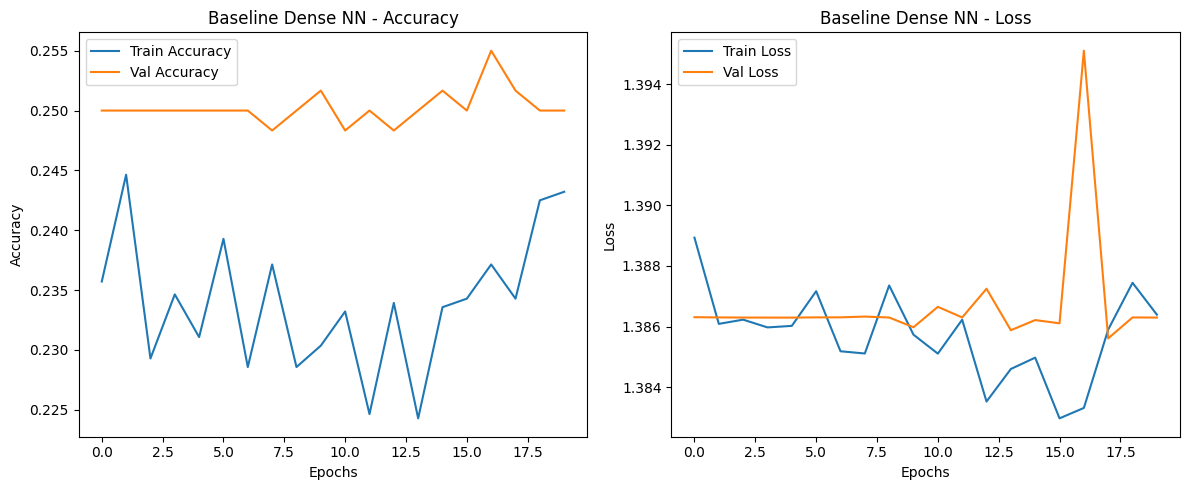

In [14]:
# Plot training history
def plot_training_history(history, title):
    plt.figure(figsize=(12, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
plot_training_history(history_baseline, "Baseline Dense NN")


In [15]:
# Evaluate on test set
test_loss, test_acc = baseline_model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Baseline Model Test Accuracy: {test_acc:.4f}")
y_pred = baseline_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=CLASSES))

Baseline Model Test Accuracy: 0.2500
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

Classification Report:
              precision    recall  f1-score   support

     Buffalo       0.00      0.00      0.00       150
    Elephant       0.25      0.98      0.40       150
       Rhino       0.40      0.01      0.03       150
       Zebra       0.50      0.01      0.01       150

    accuracy                           0.25       600
   macro avg       0.29      0.25      0.11       600
weighted avg       0.29      0.25      0.11       600



C:\Users\mayer\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\mayer\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\mayer\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

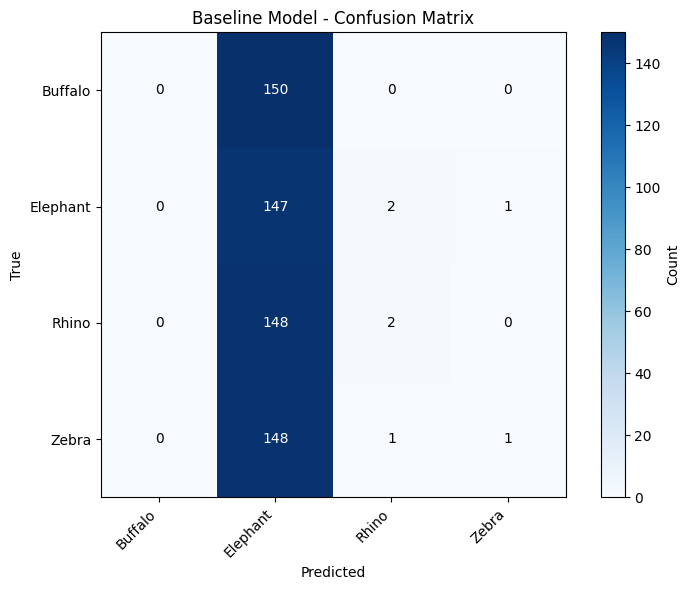

In [16]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_classes)
im = plt.imshow(cm, cmap='Blues', vmin=0, interpolation='nearest')
plt.colorbar(im, label='Count')

plt.xticks(range(len(CLASSES)), CLASSES, rotation=45, ha='right')
plt.yticks(range(len(CLASSES)), CLASSES)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Baseline Model - Confusion Matrix')

threshold = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, cm[i, j],
            ha='center', va='center',
            color='white' if cm[i, j] > threshold else 'black'
        )

plt.grid(False) 
plt.tight_layout()
plt.show()

### Baseline Limitations

Observed issues:

1. High parameter count: Flattening the images produces a very high-dimensional input, leading to millions of parameters in the first dense layer.
2. Loss of spatial structure: The flattening operation removes spatial relationships between pixels, preventing the model from learning local visual patterns.
3. No translation invariance: Similar patterns appearing at different image locations must be learned separately, reducing learning efficiency.
4. Chance-level performance: raining, validation, and test accuracy remain around 25%, which corresponds to random guessing in a four-class classification task.
5. Prediction bias toward a single class:
The model predominantly predicts one class (Elephant), resulting in near-zero recall for the remaining classes.
6. Ineffective use of additional data:
Despite a larger dataset, the dense baseline fails to improve performance, indicating that dataset size alone is insufficient without appropriate inductive bias.